In [1]:
from sklearn.datasets import make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

## Fourier feature functions

In [2]:
def gaussian_fourier(w):
    return (2*np.pi)**(-w.shape[0]/2) * np.exp(-LA.norm(w)/2)

def laplacian_fourier(w):
    p = 1
    for i in range(w.shape[0]):
        p *= 1 / (np.pi * (1 + w[i]))
    return p

## MCMC sampling method

In [3]:
def metropolis_hastings(p, dim, iter=1000):
    x = np.zeros(dim)
    samples = np.zeros((iter, dim))

    for i in range(iter):
        x_next = x + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        if np.random.rand() < p(x_next) / p(x):
            x = x_next
        samples[i] = x

    return samples

## Random Fourier features SVM class

In [4]:
class random_fourier_features_svm:
    def __init__(self, kernel_fourier=gaussian_fourier, D=500):
        self.kernel_fourier = kernel_fourier
        self.D = D
        
    def _feature_mapping(self, X, omega, bias):
        X_map = np.zeros((X.shape[0], self.D))
        for i in range(X.shape[0]):
            for j in range(self.D):
                X_map[i, j] = np.cos(np.dot(omega[j], X[i]) + bias[j]) * np.sqrt(2/self.D)
        return X_map
    
    def _draw_features(self, d, max_iter=1000):
        s = metropolis_hastings(self.kernel_fourier, dim=d, iter=max_iter)
        omega = s[np.random.randint(low=10, high=max_iter, size=self.D)]
        bias = np.random.uniform(low=0, high=2*np.pi, size=self.D)
        self.omega = omega
        self.bias = bias
        
    def fit(self, X_train, y_train, max_iter=1000, C=10):
        d = X_train.shape[-1]
        self._draw_features(d, max_iter=max_iter)
        X_train_map = self._feature_mapping(X_train, self.omega, self.bias)
        m,n = X_train_map.shape
        y_train = y_train.reshape(-1,1) * 1.
        K = np.dot(X_train_map, X_train_map.T)
        H = np.outer(y_train, y_train) * K
        
        P = matrix(H)
        q = matrix(-np.ones(m))
        G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        A = matrix(y_train, (1, m))
        b = matrix(0.)

        #Run solver
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])

        alphas = alphas.reshape(alphas.shape[0])

        sup_vec_idx = np.argwhere(np.logical_or(alphas > 1e-4, alphas < -1e-4))
        sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])
        X_sup_vec = X_train_map[sup_vec_idx]
        y_sup_vec = y_train[sup_vec_idx]
        alphas_sup_vec = alphas[sup_vec_idx]
        
        w = np.zeros(self.D)
        for i in range(alphas_sup_vec.shape[0]):
            w += alphas_sup_vec[i] * y_sup_vec[i] * X_sup_vec[i]
        b = - (np.max(np.dot(X_train_map[np.where(y_train == -1)[0]], w)) + np.min(np.dot(X_train_map[np.where(y_train == 1)[0]], w))) / 2
        self.w = w
        self.b = b
        self.sup_vec_idx = sup_vec_idx
        
    def evaluate(self, X_test, y_test):
        X_test_map = self._feature_mapping(X_test, self.omega, self.bias)
        return np.sum((np.sign(np.dot(X_test_map, self.w) + self.b) == y_test).astype("int")) / X_test_map.shape[0]

## Load nonlinear dataset

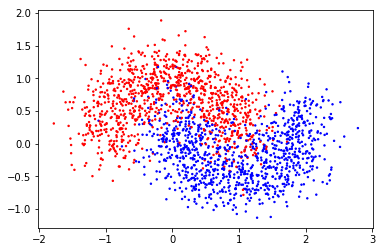

In [5]:
X, y = make_moons(n_samples=2000, noise=0.3)
colors = ['red','blue']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=2)
y[y == 0] = -1
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Fitting the training set

In [6]:
clf = random_fourier_features_svm()
clf.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.6563e+03 -5.7791e+04  1e+05  3e-01  2e-14
 1: -1.7473e+03 -1.1046e+04  1e+04  1e-02  3e-14
 2: -2.5233e+03 -5.4108e+03  3e+03  3e-03  3e-14
 3: -2.7182e+03 -4.7565e+03  2e+03  2e-03  2e-14
 4: -2.9415e+03 -3.9071e+03  1e+03  9e-04  3e-14
 5: -3.0450e+03 -3.5644e+03  5e+02  4e-04  3e-14
 6: -3.0831e+03 -3.4426e+03  4e+02  2e-04  3e-14
 7: -3.1176e+03 -3.3410e+03  2e+02  9e-05  3e-14
 8: -3.1429e+03 -3.2698e+03  1e+02  4e-05  3e-14
 9: -3.1591e+03 -3.2303e+03  7e+01  1e-05  3e-14
10: -3.1691e+03 -3.2092e+03  4e+01  6e-06  3e-14
11: -3.1756e+03 -3.1974e+03  2e+01  2e-06  4e-14
12: -3.1778e+03 -3.1924e+03  1e+01  4e-07  4e-14
13: -3.1816e+03 -3.1870e+03  5e+00  1e-07  4e-14
14: -3.1830e+03 -3.1850e+03  2e+00  3e-08  4e-14
15: -3.1835e+03 -3.1845e+03  1e+00  9e-09  4e-14
16: -3.1839e+03 -3.1840e+03  1e-01  6e-14  5e-14
17: -3.1839e+03 -3.1839e+03  6e-03  1e-13  4e-14
18: -3.1839e+03 -3.1839e+03  2e-04  2e-13  4e-14
Optimal solution foun

## Evaluating on test set

In [7]:
clf.evaluate(X_test, y_test)

0.9125

## Visualizing the support vectors

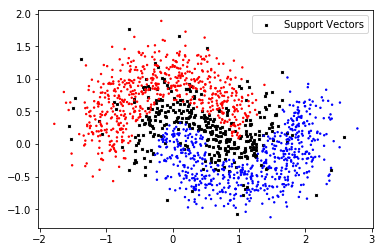

In [8]:
X_sup_vec_original = X_train[clf.sup_vec_idx]
X_non_sup_vec = X_train[~np.isin(np.arange(len(X_train)), clf.sup_vec_idx)]
y_non_sup_vec = y_train[~np.isin(np.arange(len(y_train)),clf. sup_vec_idx)]
y_non_sup_vec = y_non_sup_vec.reshape(y_non_sup_vec.shape[0])
fig, ax = plt.subplots()
colors = ['red','blue']
ax.scatter(X_sup_vec_original[:, 0], X_sup_vec_original[:, 1], c="black", s=6, marker='x', label="Support Vectors")
ax.scatter(X_non_sup_vec[:, 0], X_non_sup_vec[:, 1], c=y_non_sup_vec, cmap=matplotlib.colors.ListedColormap(colors), s=2)
ax.legend(loc="upper right")
plt.show()